In [1]:
import argparse
import os
import sys
import time

import numpy as np
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import models

from transformer_net import TransformerNet
from PIL import Image
from collections import namedtuple

from logger import Logger
from tqdm import tqdm

Let pytorch see and use only one gpu:

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

First, we need to slice VGG to be able to choose features from the layers that we need easily:

In [3]:
class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

Now we define some handy utility functions:

In [4]:
def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img

def save_image(filename, data):
    img = data.clone().mul(255).clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)

def gram_matrix(y):
    (b, ch, h, w) = y.size() # batch, channel, height, width
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.data.new(batch.data.size())
    std = batch.data.new(batch.data.size())
    mean[:, 0, :, :] = 0.485
    mean[:, 1, :, :] = 0.456
    mean[:, 2, :, :] = 0.406
    std[:, 0, :, :] = 0.229
    std[:, 1, :, :] = 0.224
    std[:, 2, :, :] = 0.225
    batch -= Variable(mean)
    batch = batch / Variable(std)
    return batch

Define some constants.

In [5]:
use_cuda = True
dataset_folder = '/data/datasets/mscoco/images'
style_image_path = './images/style-images/mosaic.jpg'
image_size = 256

batch_size = 12
lr = 1e-3
content_weight = 1e5
style_weight = 1e10

n_epochs = 1
log_interval = 50
checkpoint_model_dir = './checkpoints/'
checkpoint_interval = 2000

In [6]:
np.random.seed(42)
torch.manual_seed(42)

if use_cuda:
    torch.cuda.manual_seed(42)

Now create the dataset loader — using random crops to extend dataset.

In [7]:
transform = transforms.Compose([
    transforms.Scale(image_size+50),
    transforms.RandomCrop(image_size),
    transforms.ToTensor()
])
train_dataset = datasets.ImageFolder(dataset_folder, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

We are training only the transformer network — its architecture is defined in `transformer_net.py`.

In [8]:
transformer = TransformerNet()
optimizer = Adam(transformer.parameters(), lr)
mse_loss = torch.nn.MSELoss()

Download VGG16, load style image and compute its VGG features.

In [9]:
# Needed to make downloading work on python 2
models.vgg.model_urls['vgg16'] = models.vgg.model_urls['vgg16'].replace('https', 'http')

vgg = Vgg16(requires_grad=False)
style_transform = transforms.ToTensor()
style = load_image(style_image_path)
style = style_transform(style)
style = style.repeat(batch_size, 1, 1, 1)

if use_cuda:
    transformer.cuda()
    vgg.cuda()
    style = style.cuda()

style_v = Variable(style)
style_v = normalize_batch(style_v)
features_style = vgg(style_v)
gram_style = [gram_matrix(y) for y in features_style]

Initialize tensorboard logger.

In [10]:
logger = Logger('./logs/v001')

In [11]:
for e in range(n_epochs):
    transformer.train()
    agg_content_loss = 0.
    agg_style_loss = 0.
    count = 0
    total_batch = 0
    
    for batch_id, (x, _) in tqdm(enumerate(train_loader),
                                 total=len(train_loader)):
        total_batch += 1
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()
        x = Variable(x)
        if use_cuda:
            x = x.cuda()

        result_y = transformer(x)

        y = normalize_batch(result_y)
        x = normalize_batch(x)

        features_y = vgg(y)
        features_x = vgg(x)

        content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

        style_loss = 0.
        for ft_y, gm_s in zip(features_y, gram_style):
            gm_y = gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
        style_loss *= style_weight

        total_loss = content_loss + style_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.data[0]
        agg_style_loss += style_loss.data[0]

        if (batch_id + 1) % log_interval == 0:
            training_stats = {
                'content_loss': agg_content_loss / (batch_id + 1),
                'style_loss': agg_style_loss / (batch_id + 1),
                'total_loss': (agg_content_loss + agg_style_loss) / (batch_id + 1)
            }
            for tag, value in training_stats.items():
                logger.scalar_summary(tag, value, total_batch)
            images_info = {
                'images': result_y.data.cpu().numpy().transpose(0, 2, 3, 1).clip(0, 1)
            }
            for tag, images in images_info.items():
                logger.image_summary(tag, images, total_batch)

        if checkpoint_model_dir is not None and (batch_id + 1) % checkpoint_interval == 0:
            transformer.eval()
            if use_cuda:
                transformer.cpu()
            ckpt_model_filename = "ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
            ckpt_model_path = os.path.join(checkpoint_model_dir, ckpt_model_filename)
            torch.save(transformer.state_dict(), ckpt_model_path)
            if use_cuda:
                transformer.cuda()
            transformer.train()

 30%|██▉       | 2067/6899 [24:47<1:00:20,  1.33it/s]

KeyboardInterrupt: 

To monitor style and content losses and look at image samples, you need to launch tensorboard like this:
```
$ tensorboard --logdir=logs
```
and access it on http://localhost:6006/.

**Exercise:** Now transformed images in tensorboard are chosen randomly on each step, so when you scroll through them (in tensorboard there is a slider above each image that you can move to look at the image at different times) there is no continuity. Change the code so that the original (non-styled) images are fixed so we would be able to look at how their transformed versions evolve with more training.

Save the latest model:

In [13]:
save_model_dir = '.'

transformer.eval()
if use_cuda:
    transformer.cpu()
save_model_filename = "epoch_" + str(n_epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
    content_weight) + "_" + str(style_weight) + ".model"
save_model_path = os.path.join(save_model_dir, save_model_filename)
torch.save(transformer.state_dict(), save_model_path)

print("\nDone, trained model saved at", save_model_path)

('\nDone, trained model saved at', './epoch_1_Sat_Nov_25_02:39:05_2017_100000.0_10000000000.0.model')


A method for stylizing the image:

In [14]:
def stylize(content_image_name, content_scale, model, output_image_name):
    content_image = load_image(content_image_name, scale=content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0)
    if use_cuda:
        content_image = content_image.cuda()
    content_image = Variable(content_image, volatile=True)

    style_model = TransformerNet()
    style_model.load_state_dict(torch.load(model))
    if use_cuda:
        style_model.cuda()
    output = style_model(content_image)
    if use_cuda:
        output = output.cpu()
    output_data = output.data[0]
    save_image(output_image_name, output_data)

Stylize a sample image:

In [24]:
stylize('images/content-images/amber.jpg', 1, 'checkpoints/ckpt_epoch_0_batch_id_2000.pth', 'example.jpg')

In [20]:
import IPython

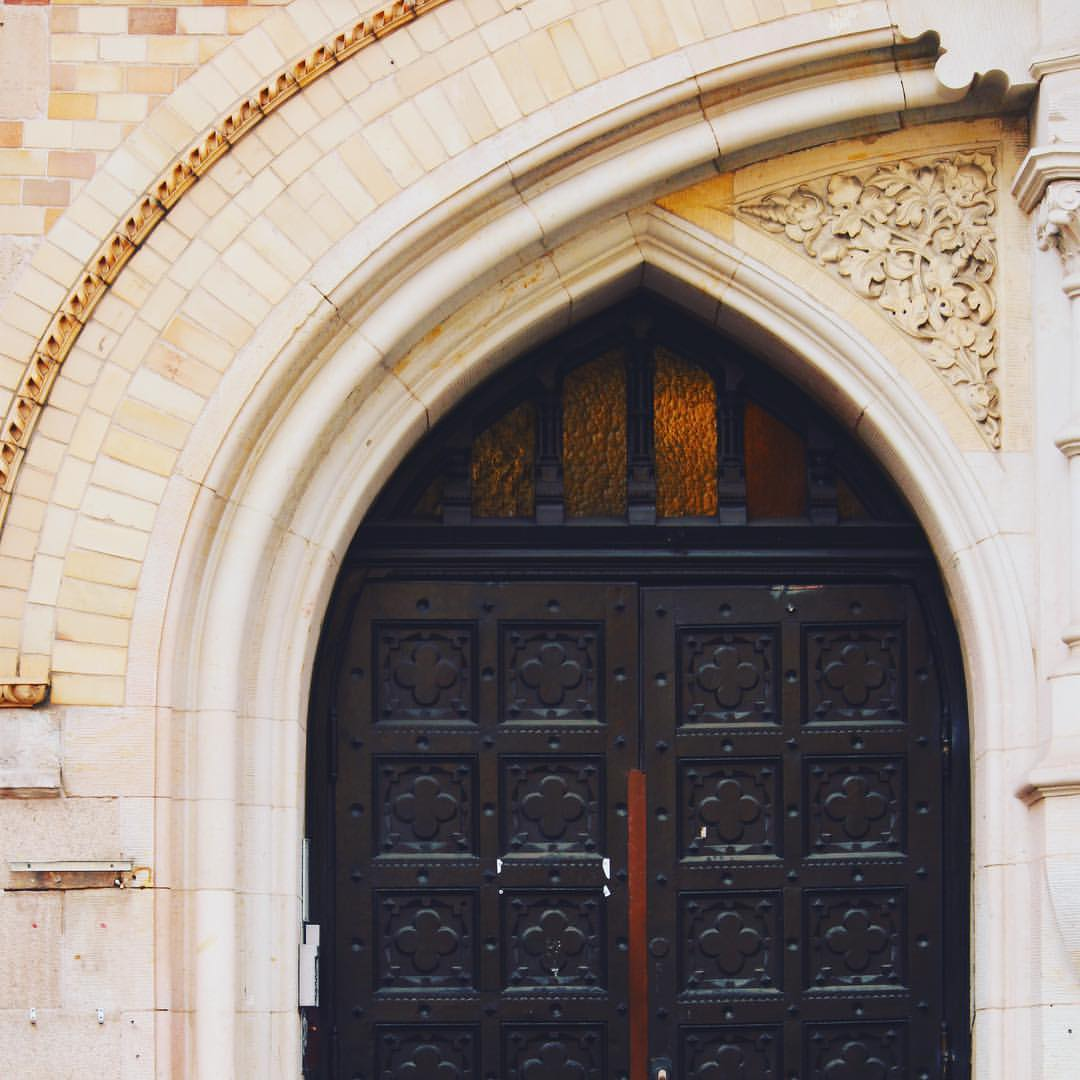

In [23]:
IPython.display.Image('images/content-images/amber.jpg', width=500)

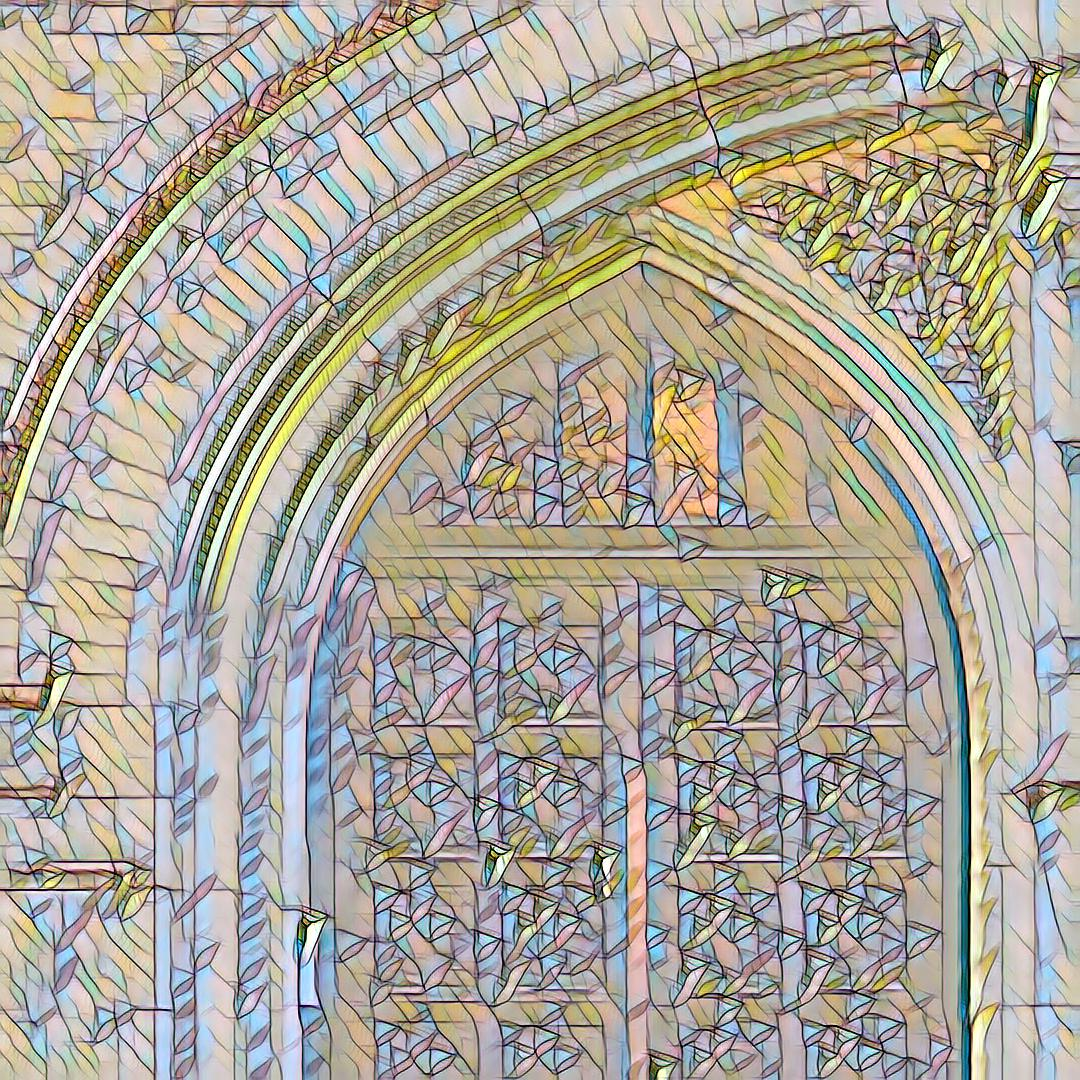

In [26]:
IPython.display.Image('example.jpg', width=500)